# Eclipse Image Processing

In which we try to make pictures better.

In [2]:
import numpy as np
import scipy as scp
import skimage as ski
from skimage import feature
import matplotlib.pyplot as plt
import skimage.io as io
import os
from tqdm import tqdm, tqdm_notebook
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt


## Useful stuff 

def image_diagnostic(img_for_show,mid_y=-1,mid_x=-1):
    if len(img_for_show.shape)>2:
        img_greyscale = ski.color.rgb2gray(img_for_show)
    else:
        img_greyscale = img_for_show
    if mid_x<0:
        mid_x=int(0.5*img_for_show.shape[0])
    if mid_y<0:
        mid_y=int(0.5*img_for_show.shape[1])

    x_slice = img_for_show[:,mid_y]
    x_len = len(x_slice)
    x_shift = 0.5*x_len
    XX = np.r_[0:x_len]-x_shift

    y_slice = img_for_show[mid_x,:]
    y_len = len(y_slice)
    y_shift = 0.5*y_len
    YY = np.r_[0:y_len]-y_shift

    plt.figure(figsize=(10, 4.5), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(2,2,1)
    plt.plot(XX,x_slice)
    plt.subplot(2,2,2)
    plt.plot(YY,y_slice)
    plt.subplot(2,2,3)
    plt.hist(np.ndarray.flatten(img_greyscale),300,log=True)
    plt.subplot(2,2,4)
    io.imshow(img_for_show)

    plt.show()

def imnorm(img):
    return img/max(np.ndarray.flatten(img))

## Functions for image registration via autocorrelation

def standard_framing(this_img,frame_size,shift=[0,0],verbose=0):
        dims = this_img.shape
        # Start by adding to the blank frame
        hdiff = frame_size[0]-dims[0]
        hhdiff = np.int(0.5*hdiff+shift[0])
        vdiff = frame_size[1]-dims[1]
        hvdiff = np.int(0.5*vdiff+shift[1])
        framed_img = np.zeros([frame_size[0],frame_size[1]])
        if verbose>0:
            print('standard_framing:')
            print(' Frame size     (%u,%u)'%(framed_img.shape))
            print(' this_img dim   (%u,%u)'%(dims[0],dims[1]))
            print(' Corner offsets (%u,%u)'%(hhdiff,hvdiff))
            
        framed_img[hhdiff:hhdiff+dims[0],hvdiff:hvdiff+dims[1]]+=this_img
        if verbose>0:
            print(' Out size       (%u,%u)'%(framed_img.shape))
            print('------- return -------')
        return framed_img

def subimage_registration(img1,img2,frame_size,subsampwidth=500,x_offset=0,
                          y_offset=0,visual=False,verbose=0):
    
    # Only necessary if not already same size
    # Doesn't require standardized image size
    blank_frame = np.int_(np.zeros([frame_size[0],frame_size[1]]))
    blank_dim = blank_frame.shape

    first_framed = standard_framing(img1,blank_dim,verbose=verbose-1)
    second_framed = standard_framing(img2,blank_dim,verbose=verbose-1)
    # There's a lot of blank space. Subsample for speed gains
    # Assumed 
    yup=np.int_(0.5*blank_dim[0]-subsampwidth)
    ybt=np.int_(0.5*blank_dim[0]+subsampwidth)
    xup=np.int_(0.5*blank_dim[1]-subsampwidth)
    xbt=np.int_(0.5*blank_dim[1]+subsampwidth)
    first_zoom = (first_framed[yup:ybt,xup:xbt])
    second_zoom = (second_framed[yup+y_offset:ybt+y_offset,xup+x_offset:xbt+x_offset])
    first_zoom = first_zoom/max(np.ndarray.flatten(first_zoom))
    second_zoom = second_zoom/max(np.ndarray.flatten(second_zoom))
    first_fft = np.fft.fft2(first_zoom)
    second_fft = np.fft.fft2(second_zoom)

    cross_fft = first_fft*second_fft.conj()
    cross_corr = np.real(np.fft.ifft2(cross_fft))

    # Locate maximum
#     search_region = cross_corr[250:750,250:750]

    maxima = np.unravel_index(np.argmax(np.abs(cross_corr)),
                              cross_corr.shape)
    midpoints = np.array([np.fix(axis_size / 2) for axis_size in cross_corr.shape])

    shifts = np.array(maxima, dtype=np.float64)
    shifts[shifts > midpoints] -= np.array(cross_corr.shape)[shifts > midpoints]
    if visual:
        plt.figure(figsize=(9,6))
        plt.subplot(231)
        plt.imshow(first_zoom)
        plt.subplot(232)
        plt.imshow(np.log(abs(first_fft)))


        plt.subplot(234)
        plt.imshow(second_zoom)
        plt.subplot(235)
        plt.imshow(np.log(abs(second_fft)))

        plt.subplot(233)
        plt.imshow((abs(cross_corr)))
        plt.subplot(236)
        plt.plot(cross_corr)
        plt.show()

    return shifts,maxima,cross_corr


def channel_registration(img_array,grey_imgs,frame_size,sigma=5,mask_level=0.4,verbose=0,subsampwidth=500,img_names=[]):
    num_imgs= len(img_array)
    
    if verbose>0:
        print('Frame size  (%u,%u)'%(frame_size[0],frame_size[1]))
    for im_idx in np.r_[0:num_imgs]:
        
        print('IMG %u/%u'%(im_idx,num_imgs))
        if len(img_names)==num_imgs:
            this_name = img_names[im_idx]
        else:
            this_name = str(im_idx)
        fname = data_root+"register_"+this_name+'.jpg'
            
        if im_idx == 0:
            old_img = imnorm(ski.filters.gaussian(grey_imgs[im_idx],sigma=sigma))
            sum_out = standard_framing(old_img,frame_size,verbose=verbose-1)
            r_sum = standard_framing(crop_imgs[im_idx][:,:,0],frame_size)
            g_sum = standard_framing(crop_imgs[im_idx][:,:,1],frame_size)
            b_sum = standard_framing(crop_imgs[im_idx][:,:,2],frame_size)
            n_sum = standard_framing(np.ones(old_img.shape),frame_size,verbose=verbose-1)
            this_rgb = this_rgb = np.dstack((r_sum,g_sum,b_sum))
            old_bin = sum_out>0.4
            if verbose>0:
                print('Setup:')
                print(' Sum shape:  (%u,%u)'%sum_out.shape)
            
            io.imsave(fname,this_rgb)
        else:
            new_img = imnorm(ski.filters.gaussian(grey_imgs[im_idx],sigma=sigma))
            new_bin = new_img>mask_level
            [shifts,maxima,cross_corr]=subimage_registration(sum_out,new_bin,frame_size,subsampwidth=subsampwidth)
            if verbose>0:
                print('IMG %u'%(im_idx))
                print(' Shifts:    (%u,%u)'%(shifts[0],shifts[1]))
                print(' sum shape: (%u,%u)'%sum_out.shape)
            new_out = standard_framing(new_img,frame_size,
                                       shift=shifts,verbose=verbose-1)

            if verbose>0:
                print(' New shape: (%u,%u)'%new_out.shape)
            sum_out += new_out
            r_new = standard_framing(crop_imgs[im_idx][:,:,0],frame_size,shift=shifts)
            g_new = standard_framing(crop_imgs[im_idx][:,:,1],frame_size,shift=shifts)
            b_new = standard_framing(crop_imgs[im_idx][:,:,2],frame_size,shift=shifts)
            n_new = standard_framing(np.ones(new_img.shape),frame_size,
                       shift=shifts,verbose=verbose-1)
            this_rgb = np.dstack((r_new,g_new,b_new))
            r_sum += r_new
            g_sum += g_new
            b_sum += b_new
            n_sum += n_new
            old_img = np.copy(new_out)
            old_bin = old_img>mask_level
            io.imsave(fname,this_rgb)
    rgb_sum = np.int_(np.r_[[r_sum],[g_sum],[b_sum]])
    io.imsave(data_root+"N_profile"+'.jpg',n_sum)
    return rgb_sum,n_sum

def rgb_histograms(img,nbins=255):
    r_sum = img[:,:,0]
    g_sum = img[:,:,1]
    b_sum = img[:,:,2]

    rhist=np.histogram(r_sum,nbins)
    rcounts = rhist[0]
  
    ghist=np.histogram(g_sum,nbins)
    gcounts = ghist[0]
  
  
    bhist=np.histogram(b_sum,nbins)
    bcounts = bhist[0]
  
    hist_bins = 0.5*(rhist[1][1:]+rhist[1][:-1])


    plt.figure(figsize=(7,7))
    plt.subplot(2,3,1)
    plt.plot(hist_bins[1:],rcounts[1:],color='red')
    plt.subplot(2,3,2)
    plt.plot(hist_bins[1:],gcounts[1:],color='green')
    plt.subplot(2,3,3)
    plt.plot(hist_bins[1:],bcounts[1:],color='blue')
    plt.subplot(2,3,4)
    plt.plot(hist_bins[1:],rcounts[1:],color='red')
    plt.yscale('log')
    plt.subplot(2,3,5)
    plt.plot(hist_bins[1:],gcounts[1:],color='green')
    plt.yscale('log')
    plt.subplot(2,3,6)
    plt.plot(hist_bins[1:],bcounts[1:],color='blue')
    plt.yscale('log')

    plt.show()
    return [np.r_[[rcounts],[gcounts],[bcounts]],rhist[1]]

# Approximately centering & cropping

In [32]:
cen_disk

array([-2147483648, -2147483648])

Starting img 0/18
Edges detected
Centre optimized


c:\users\jaker\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_io.py:141: UserWarning: C:\Users\jaker\Pictures\Oregon_Eclipse\8bit\\crop\IMG_0567.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


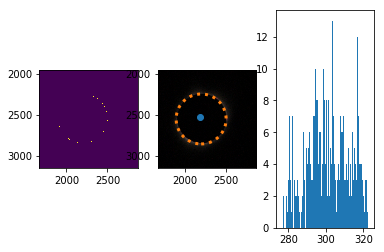

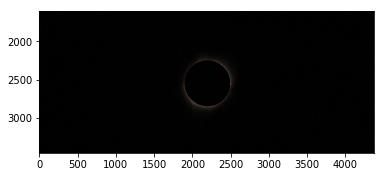

img 0 of 18:
Disk radius        (324.83 +- 181.00)
Disk centre (Y,X)  (2527,2190)
Dist to edge (X)  (3004,2190)
Dist to edge (Y)  (930,2527)
Starting img 1/18


KeyboardInterrupt: 

In [33]:
data_root = "C:\\Users\\jaker\\Pictures\\Oregon_Eclipse\\8bit\\"
dir_files=os.listdir(data_root)
img_paths = [data_root+fn for fn in dir_files if fn[0:3] == 'IMG']
img_paths=img_paths[2:]
img_imports = io.imread_collection(img_paths)
num_imgs = len(img_imports)

## Single image processing
# show the edges of the lunar disk and zoom
winsize = 600;
sm_sigma = 0.1
reopt_cutoff = 350 
opt_verbose = False
visual_out = True

def cost_fn(x,pts):
    return np.var(np.sqrt(np.sum((x.reshape(2,1)-pts)**2,axis=0)))

im_cens = np.zeros([num_imgs,2])
edge_seps = np.zeros([num_imgs,2,2])
disk_radii = np.zeros([num_imgs,2])

for im_idx in np.r_[0:num_imgs]:
    print('Starting img %u/%u'%(im_idx,num_imgs))
    filename = img_paths[im_idx][-12:]
    this_img = img_imports[im_idx]
    im_greyscale = ski.color.rgb2gray(this_img) 
    
    # Detect the edges of the lunar disk
    edges = feature.canny(im_greyscale,sigma=sm_sigma)
    edge_pts = np.nonzero(edges)
    my = int(np.mean(edge_pts[0]))+np.r_[-winsize,winsize]
    mx = int(np.mean(edge_pts[1]))+np.r_[-winsize,winsize]
    print('Edges detected')
    
    # Find the centre by minimizing the variance of the radius function
    x0 = np.mean(edge_pts,axis=1)
    opt_res=scp.optimize.minimize(lambda x: cost_fn(x,edge_pts),x0,
                                  method='nelder-mead',options={'xtol': 1e-8, 'disp': opt_verbose})

    R = np.sqrt(np.sum((opt_res.x.reshape(2,1)-edge_pts)**2,axis=0))
    print('Centre optimized')
#     # Cull points too far from disk (noise etc) and recentre
#     R_mask = R<reopt_cutoff
#     trim_pts=[edge_pts[0][R_mask],edge_pts[1][R_mask]]

#     opt_res2=scp.optimize.minimize(lambda x: cost_fn(x,trim_pts),x0,
#                                    method='nelder-mead',options={'xtol': 1e-8, 'disp': opt_verbose})

#     R2 = np.sqrt(np.sum((opt_res.x.reshape(2,1)-trim_pts)**2,axis=0))

    # Done! Write calculations for outputs
    cen_disk = np.int_(opt_res.x)
    ysep = [-cen_disk[0]+im_greyscale.shape[0],cen_disk[0]]
    xsep = [-cen_disk[1]+im_greyscale.shape[1],cen_disk[1]]
    
    [ymin,ymax] = [cen_disk[0]-min(ysep),cen_disk[0]+min(ysep)]
    [xmin,xmax] = [cen_disk[1]-min(xsep),cen_disk[1]+min(xsep)]

    ## Write the Outputs
    im_cens[im_idx] = cen_disk
    edge_seps[im_idx] = [ysep,xsep]
    disk_radii[im_idx] = [np.mean(R),np.std(R)]
    
    img_crop = this_img[ymin:ymax,xmin:xmax]
    out_fname = data_root+'\\crop\\'+filename
    io.imsave(out_fname, img_crop)
    
    ## Visual/verbose out
    if visual_out:
        theta = np.r_[0:2*np.pi:0.01]
        X = np.cos(theta)
        Y = np.sin(theta)
        r2=np.median(R)
        arc2 = [r2*X,r2*Y]+opt_res2.x.reshape(2,1)

        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(edges[my[0]:my[1],mx[0]:mx[1]],extent=[mx[0],mx[1],my[1],my[0]])
        plt.subplot(1,3,2)
        plt.imshow(this_img[my[0]:my[1],mx[0]:mx[1]],extent=[mx[0],mx[1],my[1],my[0]])
        plt.plot(opt_res.x[1],opt_res.x[0],'o')
        plt.plot(arc2[1],arc2[0],linewidth=3,linestyle='dotted')
        plt.subplot(1,3,3)
        plt.hist(R2,500)
        plt.show()
        
        plt.figure()
        plt.imshow(img_crop,extent=[xmin,xmax,ymax,ymin])
        plt.show()
    print('img %u of %u:'%(im_idx,num_imgs))
    print('Disk radius        (%.2f +- %.2f)'%(np.mean(R),np.std(R)))
    print('Disk centre (Y,X)  (%u,%u)'%(cen_disk[0],cen_disk[1]))
    print('Dist to edge (X)  (%u,%u)'%(xsep[0],xsep[1]))
    print('Dist to edge (Y)  (%u,%u)'%(ysep[0],ysep[1]))

In [16]:
this_img = np.array(img_imports[19],dtype=np.float64)
np.max(this_img)

255.0

In [20]:
from PIL import Image as pim
test_img = pim.open(img_paths[7])

In [24]:
this_img=test_img.load()


AttributeError: 'PixelAccess' object has no attribute 'shape'

In [ ]:
x_pts = np.r_[0:disk_radii.shape[0]]
plt.subplot(2,2,1)
plt.errorbar(x_pts,disk_radii[:,0],disk_radii[:,1],fmt='x')
plt.ylim([0,350])
plt.subplot(2,2,2)
plt.plot(im_cens[:,1],im_cens[:,0],'.')
plt.xlim([0,5194])
plt.ylim([0,3457])
plt.subplot(2,2,3)
plt.plot(edge_seps[:,0])
plt.subplot(2,2,4)
plt.plot(edge_seps[:,1])
plt.show()

# Pixel-scale Image Registration

https://scikit-image.org/docs/dev/auto_examples/transform/plot_register_translation.html

In [ ]:
data_root = "C:\\Users\\jaker\\Pictures\\Oregon_Eclipse\\converted\\"
dir_files=os.listdir("C:\\Users\\jaker\\Pictures\\Oregon_Eclipse\\converted\\")
crop_files = [fn for fn in dir_files if fn[0:4] == 'crop']
crop_tags = [fname[11:13] for fname in crop_files]
crop_paths = [data_root+fn for fn in dir_files if fn[0:4] == 'crop']
crop_imgs = io.imread_collection(crop_paths)
num_imgs = len(crop_imgs)
all_sizes=np.r_[[img.shape for img in crop_imgs]]
grey_imgs = [ski.color.rgb2gray(img) for img in crop_imgs]
print('%u images imported'%(num_imgs))

In [ ]:
frame_pad = 800
blank_dim = np.r_[max(all_sizes[:,0]),max(all_sizes[:,1])]
frame_size = blank_dim + np.r_[frame_pad,frame_pad]
img_array = crop_imgs

[rgb_sum,n_sum]=channel_registration(img_array,grey_imgs,frame_size,sigma=5,mask_level=0.4,verbose=2,subsampwidth=700,img_names = crop_tags)

In [ ]:
r_sum = rgb_sum[0]
g_sum = rgb_sum[1]
b_sum = rgb_sum[2]
zoom_range = [1000,3000,2000,4000]

rhist=np.histogram(r_sum,300)
rcounts = rhist[0]
ghist=np.histogram(g_sum,300)
gcounts = ghist[0]
bhist=np.histogram(b_sum,300)
bcounts = bhist[0]

hist_bins = 0.5*(rhist[1][1:]+rhist[1][:-1])


plt.figure(figsize=(9,9))
plt.subplot(221)
plt.imshow(r_sum[zoom_range[0]:zoom_range[1],zoom_range[2]:zoom_range[3]])
plt.subplot(222)
plt.imshow(g_sum[zoom_range[0]:zoom_range[1],zoom_range[2]:zoom_range[3]])
plt.subplot(223)
plt.imshow(b_sum[zoom_range[0]:zoom_range[1],zoom_range[2]:zoom_range[3]])
plt.subplot(224)
plt.imshow(n_sum)

plt.show()

plt.figure(figsize=(7,7))
plt.subplot(2,1,1)
plt.plot(hist_bins[1:],rcounts[1:],color='red')
plt.plot(hist_bins[1:],gcounts[1:],color='green')
plt.plot(hist_bins[1:],bcounts[1:],color='blue')
plt.subplot(2,1,2)
plt.plot(hist_bins[1:],rcounts[1:],color='red')
plt.plot(hist_bins[1:],gcounts[1:],color='green')
plt.plot(hist_bins[1:],bcounts[1:],color='blue')
plt.yscale('log')
plt.show()

# Understaning Noise & Dynamic Range

# Weighted sum of registered images

In [2]:
data_root = "C:\\Users\\jaker\\Pictures\\Oregon_Eclipse\\converted\\"
dir_files=os.listdir("C:\\Users\\jaker\\Pictures\\Oregon_Eclipse\\converted\\")
reg_files = [fn for fn in dir_files if fn[0:4] == 'regi']
reg_paths = [data_root+fn for fn in dir_files if fn[0:4] == 'regi']
img_tags = [fname[9:11] for fname in reg_files]
N_profile = io.imread(data_root+"N_profile.jpg")

# reg_imgs = io.imread_collection(reg_paths)
# num_imgs = len(reg_imgs)
# all_sizes=np.r_[[img.shape for img in reg_imgs]]
# grey_imgs = [ski.color.rgb2gray(img) for img in reg_imgs]
# print('%u images imported'%(num_imgs))

exposure_times={"65": 1/1250,
"66": 1/800,
"67": 1/640,
"68": 1/500,
"69": 1/400,
"70": 1/320,
"71": 1/250,
"72": 1/160,
"73": 1/100,
"74": 1/60,
"75": 1/40,
"76": 1/25,
"77": 1/20,
"78": 1/15,
"79": 1/13,
"80": 1/10,
"81": 1/8,
"83": 1/6,
"84": 1/5,
"85": 1/4,
"86": 1/3,
"87": 1/2,
"88": 0.6,
"89": 0.8,
"90": 1}



In [3]:
all_exposures=np.r_[[exposure_times[idx] for idx in img_tags]]
all_imgs=np.r_[[img for img in io.imread_collection(reg_paths)]]
num_imgs = len(all_imgs)
all_imgs.shape

(21, 4002, 5934, 3)

In [9]:
# Try: Compute the SNR in the wider sky and weight the sum accordingly
# Should scale with 1/sqrt(T), 
imsize=all_imgs.shape[1:3]
sum_image = np.zeros([imsize[0],imsize[1],3])
sqr_image = np.zeros([imsize[0],imsize[1],3])
for im_idx in np.r_[4:num_imgs]:
    scaled_img = all_imgs[im_idx]/np.sqrt(all_exposures[im_idx])
    sum_image += scaled_img
    sqr_image += (scaled_img)**2

normalizer = np.copy(N_profile)
normalizer[normalizer==0]+=1

mean_image = sum_image/normalizer.reshape(imsize[0],imsize[1],1)
var_image  = sqr_image/normalizer.reshape(imsize[0],imsize[1],1) - mean_image**2

print('Images summed')

Images summed


In [10]:
var_image[var_image<0]=0
std_image = np.sqrt(var_image/normalizer.reshape(imsize[0],imsize[1],1))

c:\users\jaker\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


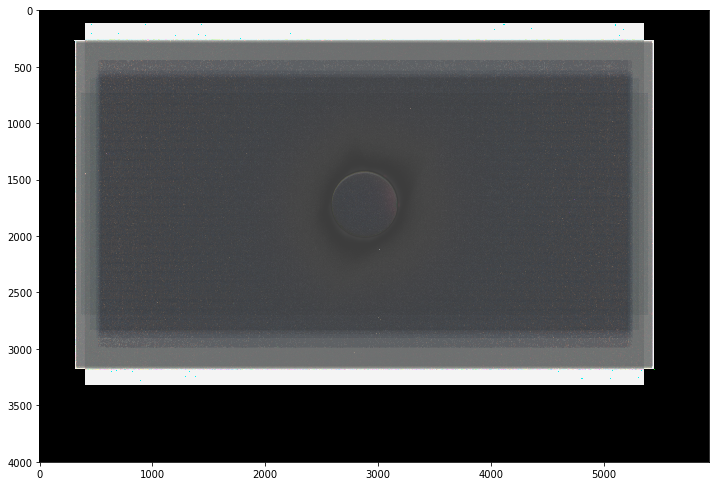

In [11]:
scaled_std_image = std_image/mean_image
plt.figure(figsize=(12,12))
plt.imshow(scaled_std_image)
plt.show()

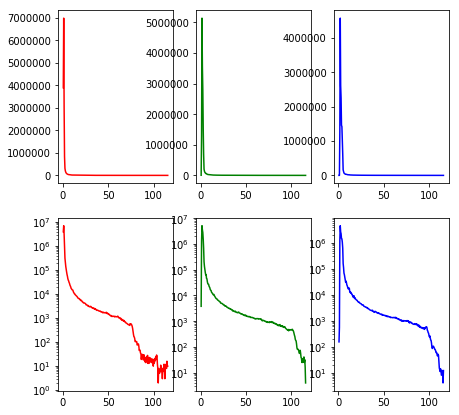

In [12]:
[rgbhists,edges]=rgb_histograms(mean_image)

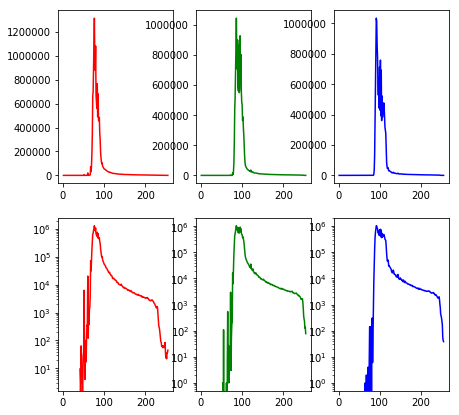

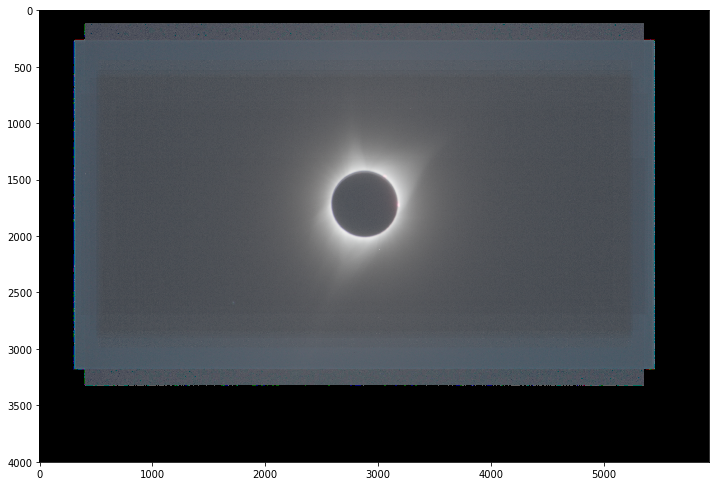

In [16]:
rescale = np.sqrt(np.sqrt(mean_image))
rescale = rgb_rescale(rescale)
[rgbhists,edges]=rgb_histograms(rescale)
plt.figure(figsize=(12,12))
plt.imshow(np.int_(rescale))
plt.show()

In [14]:
io.imsave(data_root+'summation_trial.jpg',rescale)

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


c:\users\jaker\appdata\local\programs\python\python36\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


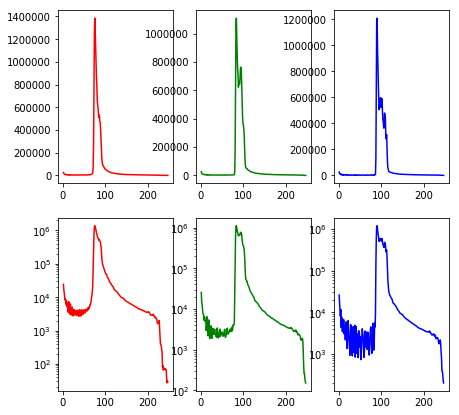

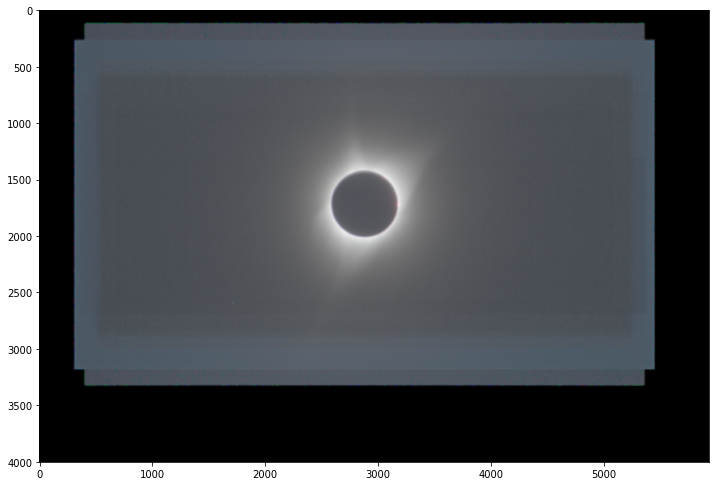

In [17]:
smooth = ski.filters.gaussian(rescale,sigma=5)
[rgbhists,edges]=rgb_histograms(smooth)
plt.figure(figsize=(12,12))
plt.imshow(np.int_(smooth))
plt.show()

# Mastering 